Preprocessing: Download genomes, and run AMRFinder on them

In [ ]:
import os, json, subprocess, shlex, sys
from pathlib import Path
import pandas as pd

# <<< EDIT THESE TO YOUR FILES >>>
INPUT_FASTAS = [
    "/Users/jackpapciak/amr_project/raw_genomes/escherichia_coli/BVBRC_escherichia_coli_genome_100_sequences.fasta",
    "//Users/jackpapciak/amr_project/raw_genomes/klebsiella_pneumoniae/BVBRC_klebsiella_pneumoniae_genome_100_sequences.fasta",
    "/Users/jackpapciak/amr_project/raw_genomes/staphylococcus_aureus/BVBRC_staphylococcus_aureus_genome_100_sequences.fasta",
]

OUT_DIR = Path("amrfinder_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

THREADS = 4  # tweak for your machine
# If you need to force a DB path, set it here; otherwise leave as None
AMRFINDER_DB = None  # e.g., Path.home() / "amrfinder_db"

In [ ]:
def run_amrfinder_on_fasta(fasta_path, out_dir=OUT_DIR, threads=THREADS, db=AMRFINDER_DB):
    """
    Runs AMRFinderPlus on a nucleotide FASTA (multi-contig allowed).
    Produces a TSV in out_dir with the same stem as the FASTA.
    Returns path to the TSV.
    """
    fasta_path = Path(fasta_path)
    out_tsv = out_dir / f"{fasta_path.stem}.amrfinder.tsv"

    # Build command
    cmd = [
        "amrfinder",
        "--nucleotide", str(fasta_path),
        "--threads", str(threads),
        "--output", str(out_tsv),
        "--plus"  # include point mutations/plus DB where possible
    ]
    if db is not None:
        cmd += ["--database", str(db)]

    print("Running:", " ".join(shlex.quote(c) for c in cmd))
    res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if res.returncode != 0:
        print("STDOUT:\n", res.stdout)
        print("STDERR:\n", res.stderr, file=sys.stderr)
        raise RuntimeError(f"AMRFinder failed on {fasta_path}")
    return out_tsv

# Test dry-run printing:
for f in INPUT_FASTAS:
    print("Will run:", f)


In [ ]:
# this runs AMRFinder in the cell, but you can run in terminal to be more efficient
tsv_paths = []
for fasta in INPUT_FASTAS:
    tsv = run_amrfinder_on_fasta(fasta)
    tsv_paths.append(tsv)

tsv_paths


In [ ]:
tsv_paths = [
    "/Users/jackpapciak/amr_project/misc/amrfinder_outputs/BVBRC_escherichia_coli_genome_100_sequences.amrfinder.tsv",
    "/Users/jackpapciak/amr_project/misc/amrfinder_outputs/BVBRC_klebsiella_pneumoniae_genome_100_sequences.amrfinder.tsv",
    "/Users/jackpapciak/amr_project/misc/amrfinder_outputs/BVBRC_staphylococcus_aureus_genome_100_sequences.amrfinder.tsv",
]

In [ ]:
def load_amrfinder_tsv(tsv_path):
    # AMRFinderPlus outputs tab-delimited with header
    df = pd.read_csv(tsv_path, sep="\t", comment="#", dtype=str).fillna("")
    # normalize column names (some versions vary slightly)
    cols = {c.lower().strip(): c for c in df.columns}
    # pick best-guess canonical names
    contig_col = next((cols[k] for k in cols if k in ["contig id", "contig", "sequence"]), None)
    class_col  = next((cols[k] for k in cols if k in ["class", "drug class", "drug_class"]), None)
    subclass_col = next((cols[k] for k in cols if k in ["subclass", "drug subclass", "drug_subclass"]), None)
    gene_col   = next((cols[k] for k in cols if k in ["gene symbol", "gene", "symbol"]), None)
    aro_col    = next((cols[k] for k in cols if k in ["aro accession", "aro", "aro_accession"]), None)

    # keep a compact subset for downstream
    keep = [c for c in [contig_col, class_col, subclass_col, gene_col, aro_col] if c]
    sub = df[keep].copy()
    sub.columns = ["contig_id", "class", "subclass", "gene_symbol", "aro_id"][:len(keep)]
    return sub

# Load all TSVs and add source tag
amr_hits = []
for tsv in tsv_paths:
    sdf = load_amrfinder_tsv(tsv)
    sdf["source_file"] = Path(tsv).stem.replace(".amrfinder","")
    amr_hits.append(sdf)

amr_hits = pd.concat(amr_hits, ignore_index=True)
amr_hits.head()


In [ ]:
# Canonicalize class strings a bit
def clean_class(x):
    x = (x or "").strip()
    # simple canonicalization
    return x.replace("_", " ").replace("-", " ").title()

amr_hits["class"] = amr_hits["class"].map(clean_class)

# Build master class list
all_classes = sorted([c for c in amr_hits["class"].unique() if c])
class_to_idx = {c:i for i,c in enumerate(all_classes)}
all_classes

# Aggregate to contig-level labels
labels = (
    amr_hits[amr_hits["class"] != ""]
    .groupby(["source_file","contig_id"])["class"]
    .apply(lambda xs: sorted(set(xs)))
    .reset_index()
)
labels.head()

import numpy as np

def classes_to_multihot(classes, class_to_idx):
    vec = np.zeros(len(class_to_idx), dtype=np.int8)
    for c in classes:
        if c in class_to_idx:
            vec[class_to_idx[c]] = 1
    return vec

labels["label_vector"] = labels["class"].apply(lambda cs: classes_to_multihot(cs, class_to_idx))
labels.head()


In [ ]:
# AMR-positive contigs = those with ≥1 class
pos = labels.copy()
pos["is_amr_positive"] = True
pos = pos[["source_file","contig_id","class","is_amr_positive","label_vector"]]

# To get negatives, enumerate all contigs from each FASTA and subtract positives
from itertools import chain

def all_contig_ids_from_fasta(fasta_path):
    ids = []
    with open(fasta_path) as f:
        for line in f:
            if line.startswith(">"):
                ids.append(line[1:].strip().split()[0])
    return ids

all_contigs = []
for fasta in INPUT_FASTAS:
    src = Path(fasta).stem
    ids = all_contig_ids_from_fasta(fasta)
    all_contigs.extend([(src, cid) for cid in ids])

all_df = pd.DataFrame(all_contigs, columns=["source_file","contig_id"])
neg = all_df.merge(pos[["source_file","contig_id","is_amr_positive"]], on=["source_file","contig_id"], how="left")
neg = neg[neg["is_amr_positive"].isna()].drop(columns=["is_amr_positive"])
neg["is_amr_positive"] = False
neg["class"] = [[] for _ in range(len(neg))]
neg["label_vector"] = [np.zeros(len(class_to_idx), dtype=np.int8) for _ in range(len(neg))]

pos.shape, neg.shape


In [ ]:
combined = pd.concat([pos, neg], ignore_index=True)
combined["num_classes"] = combined["label_vector"].apply(lambda v: int(np.sum(v)))
combined.head()

# Save artifacts
OUT_DIR.mkdir(exist_ok=True, parents=True)
combined_path = OUT_DIR / "contig_amr_labels.parquet"
classes_path  = OUT_DIR / "amr_class_list.json"

combined.to_parquet(combined_path, index=False)
with open(classes_path, "w") as jf:
    json.dump({"class_list": all_classes}, jf, indent=2)

combined_path, classes_path


In [ ]:
# Pos/neg counts per file
summary = (
    combined.groupby(["source_file","is_amr_positive"])
    .size().unstack(fill_value=0)
    .rename(columns={False:"neg", True:"pos"})
)
summary


In [ ]:

# Top AMR classes observed
top_classes = (
    amr_hits[amr_hits["class"]!=""]
    .groupby("class").size().sort_values(ascending=False).head(20)
)
top_classes


END OF PREPROCESSING

1) Configure paths & load data

In [1]:
import json, ast
import pandas as pd
from pathlib import Path

ARTIFACTS_DIR = Path("/Users/jackpapciak/amr_project/misc/amrfinder_outputs")
LABELS_PARQUET = ARTIFACTS_DIR / "contig_amr_labels.parquet"
CLASSES_JSON   = ARTIFACTS_DIR / "amr_class_list.json"

df = pd.read_parquet(LABELS_PARQUET)

# Ensure label_vector is a Python list (parquet sometimes preserves it, sometimes stores as string)
def _to_list(x):
    if isinstance(x, (list, tuple)): 
        return list(x)
    if isinstance(x, str):
        try:
            return json.loads(x)
        except Exception:
            try:
                return ast.literal_eval(x)
            except Exception:
                return []
    return []

df["label_vector"] = df["label_vector"].apply(_to_list)

with open(CLASSES_JSON) as f:
    class_list = json.load(f)["class_list"]

print("Rows:", len(df), "AMR classes:", len(class_list))
df.head()


Rows: 29176 AMR classes: 35


,source_file,contig_id,class,is_amr_positive,label_vector,num_classes
0,BVBRC_escherichia_coli_genome_100_sequences,accn|JAAARR010000017,[Efflux],True,[],1
1,BVBRC_escherichia_coli_genome_100_sequences,accn|JAAARR010000059,[Efflux],True,[],1
2,BVBRC_escherichia_coli_genome_100_sequences,accn|JAAARR010000076,[Aminoglycoside],True,[],1
3,BVBRC_escherichia_coli_genome_100_sequences,accn|JAAARR010000137,[Efflux],True,[],1
4,BVBRC_escherichia_coli_genome_100_sequences,accn|JAAARR010000191,"[Aminoglycoside, Sulfonamide]",True,[],2


In [2]:
from collections import ChainMap

FASTA_FILES = [
    "/Users/jackpapciak/amr_project/raw_genomes/escherichia_coli/BVBRC_escherichia_coli_genome_100_sequences.fasta",
    "/Users/jackpapciak/amr_project/raw_genomes/klebsiella_pneumoniae/BVBRC_klebsiella_pneumoniae_genome_100_sequences.fasta",
    "/Users/jackpapciak/amr_project/raw_genomes/staphylococcus_aureus/BVBRC_staphylococcus_aureus_genome_100_sequences.fasta",
]

def fasta_to_map(path):
    m = {}
    with open(path, "r") as fh:
        header = None
        chunks = []
        for line in fh:
            if line.startswith(">"):
                if header is not None:
                    m[header] = "".join(chunks)
                header = line[1:].strip().split()[0]  # first token only
                chunks = []
            else:
                s = line.strip()
                if s:
                    chunks.append(s)
        if header is not None:
            m[header] = "".join(chunks)
    return m

seq_maps = [fasta_to_map(p) for p in FASTA_FILES]
SEQ_MAP = dict(ChainMap(*seq_maps))

print("Total unique contig IDs parsed from FASTAs:", len(SEQ_MAP))


Total unique contig IDs parsed from FASTAs: 29176


In [3]:
# Attach exact matches
df["sequence"] = df["contig_id"].map(SEQ_MAP)

missing = df["sequence"].isna().sum()
print("Missing after exact match:", missing)

# Fallback: try last pipe-delimited token (e.g., "GCF...|QYNR01000001.1" -> "QYNR01000001.1")
def right_of_pipe(x):
    t = str(x)
    return t.split("|")[-1] if "|" in t else t

if missing:
    df.loc[df["sequence"].isna(), "sequence"] = (
        df.loc[df["sequence"].isna(), "contig_id"].map(lambda cid: SEQ_MAP.get(right_of_pipe(cid), None))
    )
    missing2 = df["sequence"].isna().sum()
    print("Missing after pipe-normalization:", missing2)

# Final sanity check
n_missing = df["sequence"].isna().sum()
if n_missing:
    print(f"WARNING: {n_missing} contigs still lack sequences. Show a few examples:")
    display(df.loc[df["sequence"].isna(), ["contig_id"]].head(10))
else:
    print("All contigs have sequences.")


Missing after exact match: 0
All contigs have sequences.


In [4]:
# NEW === Build AMR label vectors from AMRFinder TSVs AND report pos/neg by species ===
import json, ast, re
import numpy as np
import pandas as pd
from pathlib import Path

# ----------------------------------------------------------------------
# 0) EDIT THESE PATHS to your actual AMRFinder TSVs and FASTAs (for species mapping)
# ----------------------------------------------------------------------
TSV_PATHS = [
    "/Users/jackpapciak/amr_project/misc/amrfinder_outputs/BVBRC_escherichia_coli_genome_100_sequences.amrfinder.tsv",
    "/Users/jackpapciak/amr_project/misc/amrfinder_outputs/BVBRC_klebsiella_pneumoniae_genome_100_sequences.amrfinder.tsv",
    "/Users/jackpapciak/amr_project/misc/amrfinder_outputs/BVBRC_staphylococcus_aureus_genome_100_sequences.amrfinder.tsv",
]

FASTA_FILES = [
    "/Users/jackpapciak/amr_project/raw_genomes/escherichia_coli/BVBRC_escherichia_coli_genome_100_sequences.fasta",
    "/Users/jackpapciak/amr_project/raw_genomes/klebsiella_pneumoniae/BVBRC_klebsiella_pneumoniae_genome_100_sequences.fasta",
    "/Users/jackpapciak/amr_project/raw_genomes/staphylococcus_aureus/BVBRC_staphylococcus_aureus_genome_100_sequences.fasta",
]

# ----------------------------------------------------------------------
# 1) Load AMRFinder TSVs with robust header handling
# ----------------------------------------------------------------------
def load_amrfinder_tsv(tsv_path: str) -> pd.DataFrame:
    """
    Normalize key columns:
      contig_id, class, (optional) subclass, gene_symbol, aro_id
    Handles header variants like 'Contig id' vs 'Contig', 'Class' vs 'Drug Class', etc.
    """
    df = pd.read_csv(tsv_path, sep="\t", comment="#", dtype=str).fillna("")
    lname = {c.lower().strip(): c for c in df.columns}

    def pick(*cands):
        for k in cands:
            if k in lname:
                return lname[k]
        return None

    contig_col   = pick("contig id", "contig", "sequence")
    class_col    = pick("class", "drug class", "drug_class")
    subclass_col = pick("subclass", "drug subclass", "drug_subclass")
    gene_col     = pick("gene symbol", "gene", "symbol", "sequence name")
    aro_col      = pick("aro accession", "aro", "aro_accession")

    if contig_col is None or class_col is None:
        raise ValueError(f"Missing required columns in {tsv_path}. Found: {list(df.columns)}")

    keep = [c for c in [contig_col, class_col, subclass_col, gene_col, aro_col] if c]
    out = df[keep].copy()

    # Standardize names
    new_cols = []
    for c in keep:
        lc = c.lower()
        if lc == contig_col.lower():           new_cols.append("contig_id")
        elif lc == class_col.lower():          new_cols.append("class")
        elif subclass_col and lc == subclass_col.lower(): new_cols.append("subclass")
        elif gene_col and lc == gene_col.lower():         new_cols.append("gene_symbol")
        elif aro_col and lc == aro_col.lower():           new_cols.append("aro_id")
        else: new_cols.append(c)
    out.columns = new_cols
    return out

hits_list = []
for p in TSV_PATHS:
    p = Path(p)
    if not p.exists():
        raise FileNotFoundError(f"Missing TSV: {p}")
    hits_list.append(load_amrfinder_tsv(str(p)))

amr_hits = pd.concat(hits_list, ignore_index=True)
amr_hits["class"] = amr_hits["class"].astype(str).str.strip()
amr_hits = amr_hits[amr_hits["class"] != ""]

# Optional: filter out non-antibiotic classes (metals/biocides) if desired
# keep_mask = ~amr_hits["class"].str.contains(
#     r"Arsenic|Cadmium|Copper|Mercury|Silver|Nickel|Quaternary Ammonium", case=False
# )
# amr_hits = amr_hits[keep_mask]

# Build AMR class list and mapping
class_list = sorted(amr_hits["class"].unique().tolist())
class2idx = {c:i for i,c in enumerate(class_list)}
print(f"Detected {len(class_list)} AMR classes.")
# ----------------------------------------------------------------------
# 2) Attach multi-hot AMR vectors to your df (expects df with contig_id)
# ----------------------------------------------------------------------
assert "contig_id" in df.columns, "df must contain a 'contig_id' column."

cid_to_classes = (
    amr_hits.groupby("contig_id")["class"]
    .apply(lambda s: sorted(set(s.tolist())))
    .to_dict()
)

def build_vec(cid):
    vec = np.zeros(len(class_list), dtype=np.float32)
    for c in cid_to_classes.get(str(cid), []):
        vec[class2idx[c]] = 1.0
    return vec

df["label_vector"]    = df["contig_id"].astype(str).apply(build_vec)
df["is_amr_positive"] = df["label_vector"].apply(lambda v: float(np.sum(v)) > 0)

n_pos = int(df["is_amr_positive"].sum())
print(f"Rows: {len(df)} | AMR-positive contigs: {n_pos} ({n_pos/len(df):.3%})")

# ----------------------------------------------------------------------
# 3) Map contig -> species using the FASTA files (for per-species counts)
# ----------------------------------------------------------------------
def fasta_contig_species_map(fasta_path: str, species_label: str) -> dict:
    m = {}
    with open(fasta_path, "r") as fh:
        header = None
        for line in fh:
            if line.startswith(">"):
                header = line[1:].strip().split()[0]
                if header:
                    m[header] = species_label
    return m

def infer_species_name_from_path(fp: str) -> str:
    # Try folder name (e.g., 'escherichia_coli') → 'Escherichia coli'
    parts = Path(fp).parts
    guess = None
    for seg in reversed(parts):
        if seg and seg.lower() in {"escherichia_coli","klebsiella_pneumoniae","staphylococcus_aureus"}:
            guess = seg.replace("_"," ").title()
            break
    if guess is None:
        # fallback: parse within filename like BVBRC_<genus>_<species>_genome...
        m = re.search(r"BVBRC_([A-Za-z]+)_([A-Za-z]+)_genome", Path(fp).name)
        if m:
            guess = f"{m.group(1).title()} {m.group(2).lower()}"
        else:
            guess = Path(fp).stem
    # Normalize common species casing
    guess = guess.replace("Escherichia coli", "Escherichia coli")
    guess = guess.replace("Klebsiella pneumoniae", "Klebsiella pneumoniae")
    guess = guess.replace("Staphylococcus aureus", "Staphylococcus aureus")
    return guess

CONTIG_TO_SPECIES = {}
for fp in FASTA_FILES:
    species = infer_species_name_from_path(fp)
    CONTIG_TO_SPECIES.update(fasta_contig_species_map(fp, species))

df["species"] = df["contig_id"].astype(str).map(CONTIG_TO_SPECIES).fillna("Unknown")

# ----------------------------------------------------------------------
# 4) Per-species pos/neg counts + rates
# ----------------------------------------------------------------------
by_species = (
    df.groupby(["species","is_amr_positive"])
      .size().unstack(fill_value=0)
      .rename(columns={False:"neg", True:"pos"})
      .assign(total=lambda t: t["pos"] + t["neg"],
              pos_rate=lambda t: t["pos"] / t["total"].replace(0, np.nan))
      .sort_values("total", ascending=False)
)

print("\nPer-species AMR counts:")
display(by_species)

# If you want a compact printout for the report:
print("\nTable (copy-ready):")
print(by_species[["neg","pos","total","pos_rate"]].to_string())


Detected 35 AMR classes.
Rows: 29176 | AMR-positive contigs: 2605 (8.929%)

Per-species AMR counts:


is_amr_positive,neg,pos,total,pos_rate
species,,,,
Escherichia Coli,11719,799,12518,0.063828
Klebsiella Pneumoniae,9068,1166,10234,0.113934
Staphylococcus Aureus,5784,640,6424,0.099626



Table (copy-ready):
is_amr_positive          neg   pos  total  pos_rate
species                                            
Escherichia Coli       11719   799  12518  0.063828
Klebsiella Pneumoniae   9068  1166  10234  0.113934
Staphylococcus Aureus   5784   640   6424  0.099626


2) Prepare tensors (sequence hashing, multi-label AMR, taxonomy)

In [5]:
import numpy as np

# ==== Speed-tunable params ====
K = 5                # try 4–5 for speed; raise later for accuracy
VOCAB_BUCKETS = 4096  # try 512–2048 for quick runs; 4096+ later
STRIDE = 1           # process every STRIDE-th k-mer (2–3 is much faster)
MAX_LEN = None       # cap processed prefix per contig; set None to disable
# ==============================

def hash_kmers_fast(seq, k=K, buckets=VOCAB_BUCKETS, stride=STRIDE, max_len=MAX_LEN):
    v = np.zeros(buckets, dtype=np.float32)
    s = str(seq).upper()
    if max_len is not None and len(s) > max_len:
        s = s[:max_len]
    n = len(s) - k + 1
    if n <= 0:
        return v
    i = 0
    while i < n:
        w = s[i:i+k]
        # skip windows with non-ACGT
        bad = False
        for c in w:
            oc = ord(c)
            if oc not in (65, 67, 71, 84):  # A,C,G,T
                bad = True
                break
        if not bad:
            h = 0
            for c in w:
                h = (h * 131 + ord(c)) & 0xFFFFFFFF
            v[h % buckets] += 1.0
        i += stride
    return np.log1p(v)

# Expect df with these columns
assert "sequence" in df.columns, "Expected a 'sequence' column with contig DNA"
assert "label_vector" in df.columns, "Expected a 'label_vector' (list/array) per row"

# Build matrices
X_seq = np.stack([hash_kmers_fast(s) for s in df["sequence"].values])
Y_amr = np.stack([np.array(v, dtype=np.float32) for v in df["label_vector"].values])

print(f"X_seq: {X_seq.shape}  Y_amr: {Y_amr.shape}  (k={K}, buckets={VOCAB_BUCKETS}, stride={STRIDE}, max_len={MAX_LEN})")




X_seq: (29176, 4096)  Y_amr: (29176, 35)  (k=5, buckets=4096, stride=1, max_len=None)


3) Poincaré ball ops (hyperbolic geometry in pure PyTorch)

In [6]:
# === Cell 3: Hyperbolic ops (Poincaré ball) ===
import torch
from torch import nn

EPS = 1e-7

def _acosh(x: torch.Tensor) -> torch.Tensor:
    # numerically stable acosh: acosh(x) = log(x + sqrt(x^2 - 1))
    z = torch.clamp(x, min=1.0 + 1e-12)
    return torch.log(z + torch.sqrt(torch.clamp(z*z - 1.0, min=0.0) + 1e-12))

class PoincareBall:
    """Poincaré ball of curvature -c (with c>0). Uses unit ball; c rescales distances."""
    def __init__(self, c: float = 1.0):
        self.c = float(c)

    def proj(self, x: torch.Tensor) -> torch.Tensor:
        # keep points strictly inside the ball
        norm = torch.norm(x, dim=-1, keepdim=True) + EPS
        max_norm = 1.0 - 1e-3
        scale = torch.clamp(max_norm / norm, max=1.0)
        return x * scale

    def mobius_add(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        c = self.c
        xy = 2*c*torch.sum(x*y, dim=-1, keepdim=True)
        x2 = c*torch.sum(x*x, dim=-1, keepdim=True)
        y2 = c*torch.sum(y*y, dim=-1, keepdim=True)
        num = (1 + xy + y2) * x + (1 - x2) * y
        den = 1 + xy + x2*y2
        return num / torch.clamp(den, min=EPS)

    def lambda_x(self, x: torch.Tensor) -> torch.Tensor:
        c = self.c
        x2 = torch.clamp(c*torch.sum(x*x, dim=-1, keepdim=True), min=0.0, max=1.0-1e-6)
        return 2.0 / torch.clamp(1.0 - x2, min=EPS)

    def distance(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # d(x,y) = acosh(1 + 2||x-y||^2 / ((1-||x||^2)(1-||y||^2)))
        x2 = torch.sum(x*x, dim=-1)
        y2 = torch.sum(y*y, dim=-1)
        diff2 = torch.sum((x - y)**2, dim=-1)

        den = torch.clamp((1.0 - x2) * (1.0 - y2), min=EPS)
        z = 1.0 + 2.0 * diff2 / den
        return _acosh(z)

BALL = PoincareBall(c=1.0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

4) Model: sequence/AMR/taxon → shared hyperbolic space

In [7]:
# === Cell 4: HyperAMR model (sequence + AMR (+ optional taxonomy)) ===
import math

D_SEQ = int(X_seq.shape[1])      # input dimension (k-mer hash space)
D_AMR = int(len(class_list))     # multi-label dimension
D_EMB = 64                       # hyperbolic embedding dimension

class HyperAMR(nn.Module):
    def __init__(self, use_taxonomy: bool = False, n_taxa: int = 0):
        super().__init__()
        self.use_taxonomy = use_taxonomy

        # Encoders (Euclidean -> then projected into ball)
        self.seq_enc = nn.Sequential(
            nn.Linear(D_SEQ, 256),
            nn.ReLU(),
            nn.Linear(256, D_EMB)
        )
        self.amr_enc = nn.Sequential(
            nn.Linear(D_AMR, 128),
            nn.ReLU(),
            nn.Linear(128, D_EMB)
        )

        if use_taxonomy and n_taxa > 0:
            self.taxon = nn.Embedding(n_taxa, D_EMB)
            nn.init.uniform_(self.taxon.weight, a=-0.01, b=0.01)
        else:
            self.taxon = None

        # Decoder head from (Euclidean proxy) -> AMR logits
        self.dec_amr = nn.Sequential(
            nn.Linear(D_EMB, 128),
            nn.ReLU(),
            nn.Linear(128, D_AMR)
        )

    def _to_ball(self, z_euc: torch.Tensor) -> torch.Tensor:
        # squashing + projection to keep inside unit ball
        return BALL.proj(torch.tanh(z_euc))

    def forward(self, x_seq, x_amr=None, tax_idx=None):
        z_seq_e = self.seq_enc(x_seq)
        z_seq = self._to_ball(z_seq_e)

        outputs = {"z_seq": z_seq, "z_seq_e": z_seq_e}

        if x_amr is not None:
            z_amr_e = self.amr_enc(x_amr)
            z_amr = self._to_ball(z_amr_e)
            outputs.update({"z_amr": z_amr, "z_amr_e": z_amr_e})

        if self.taxon is not None and tax_idx is not None:
            z_tax_e = self.taxon(tax_idx)
            z_tax = self._to_ball(z_tax_e)
            outputs.update({"z_tax": z_tax, "z_tax_e": z_tax_e})

        # Decoder uses Euclidean proxy (detach keeps it as a probe on representations)
        outputs["amr_logits"] = self.dec_amr(z_seq_e.detach())
        return outputs


5) Losses: InfoNCE alignment, stacked entailment (radial), supervised AMR

In [8]:
# === Cell 5: Losses (InfoNCE, stacked entailment, supervised BCE) ===
import torch.nn.functional as F

def pairwise_hyperbolic_distance(A: torch.Tensor, B: torch.Tensor) -> torch.Tensor:
    # Compute pairwise hyperbolic distances between rows of A (BxD) and B (BxD) -> (B,B)
    # Broadcast trick: expand and compute BALL.distance row-wise
    # For efficiency, approximate with Euclidean cdist on ball coords is also acceptable; here we do exact per-row
    # using vectorized expansion.
    Bn, D = A.shape
    A_exp = A.unsqueeze(1).expand(Bn, Bn, D)  # (B,B,D)
    B_exp = B.unsqueeze(0).expand(Bn, Bn, D)  # (B,B,D)
    # Flatten -> compute distance -> reshape
    flatA = A_exp.reshape(-1, D)
    flatB = B_exp.reshape(-1, D)
    d = BALL.distance(flatA, flatB).reshape(Bn, Bn)
    return d

def info_nce_hyper(z1: torch.Tensor, z2: torch.Tensor, temperature: float = 0.2) -> torch.Tensor:
    """
    Contrastive alignment: match i-th row of z1 to i-th row of z2.
    Uses hyperbolic distance on the ball (smaller is better).
    """
    B = z1.size(0)
    d = pairwise_hyperbolic_distance(z1, z2)   # (B,B)
    logits = -d / temperature
    labels = torch.arange(B, device=z1.device)
    return nn.CrossEntropyLoss()(logits, labels)

def stacked_entailment_radial(z_parent: torch.Tensor, z_child: torch.Tensor, margin: float = 0.05) -> torch.Tensor:
    """
    Enforce radial ordering: children should lie farther from origin than parents (hierarchy expands outward).
    """
    r_par   = torch.norm(z_parent, dim=-1)
    r_child = torch.norm(z_child, dim=-1)
    return torch.relu(margin + r_par - r_child).mean()

def bce_with_pos_weight(logits: torch.Tensor, targets: torch.Tensor, pos_weight: torch.Tensor | None = None) -> torch.Tensor:
    return F.binary_cross_entropy_with_logits(logits, targets, pos_weight=pos_weight)


6) Taxonomy edges (optional)

In [9]:
# === Cell 6: (Optional) Taxonomy edges -> index tensor ===
import pandas as pd
import torch

def load_taxonomy_edges(edges_tsv_path: str, taxid2idx: dict[str,int]) -> torch.Tensor | None:
    """
    Expect a TSV with two columns (no header): child_taxid \t parent_taxid
    Returns a LongTensor of shape (E, 2) with child_idx, parent_idx for known IDs.
    """
    p = Path(edges_tsv_path)
    if not p.exists():
        return None
    edges = pd.read_csv(p, sep="\t", header=None, names=["child","parent"], dtype=str)
    edges = edges[edges["child"].isin(taxid2idx) & edges["parent"].isin(taxid2idx)]
    if edges.empty:
        return None
    idx = torch.tensor([[taxid2idx[c], taxid2idx[p]] for c,p in edges[["child","parent"]].values],
                       dtype=torch.long)
    return idx


7) Dataset / DataLoader

In [10]:
# == Cell 7 (drop-in) ==
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Expect in scope from earlier cells:
# - X_seq: np.ndarray [N, D_SEQ]
# - Y_amr: np.ndarray [N, D_AMR]
# - df: pandas DataFrame with a 'split' column ('train'/'val'/'test')
# - (optional) tax_idx: np.ndarray [N] of ints (if you built it); else omitted/None

# 1) Build / check split
if 'split' not in df.columns:
    # simple 80/20 split if none provided (fixed seed for reproducibility)
    rng = np.random.default_rng(42)
    mask = rng.random(len(df)) < 0.8
    split = np.where(mask, 'train', 'val')
    df = df.copy()
    df['split'] = split

idx_train = np.where(df['split'].values == 'train')[0]
idx_val   = np.where(df['split'].values == 'val')[0]

X_train, Y_train = X_seq[idx_train], Y_amr[idx_train]
X_val,   Y_val   = X_seq[idx_val],   Y_amr[idx_val]

# Optional taxonomy indices; if you never computed them, just make zeros.
USE_TAX = ('taxid' in df.columns) and USE_TAXONOMY  # USE_TAXONOMY from your earlier flag
if USE_TAX and 'taxid2idx' in globals():
    tax_full = np.array([taxid2idx[str(t)] for t in df['taxid'].astype(str)], dtype=np.int64)
    T_train, T_val = tax_full[idx_train], tax_full[idx_val]
else:
    T_train = np.zeros(len(idx_train), dtype=np.int64)
    T_val   = np.zeros(len(idx_val),   dtype=np.int64)

class ContigDataset(Dataset):
    def __init__(self, X, Y, T=None):
        self.X = torch.as_tensor(X, dtype=torch.float32)
        self.Y = torch.as_tensor(Y, dtype=torch.float32)
        if T is None:
            T = np.zeros(len(X), dtype=np.int64)
        self.T = torch.as_tensor(T, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        # Always return tensors (no None) so default_collate works
        return self.X[i], self.Y[i], self.T[i]

train_ds = ContigDataset(X_train, Y_train, T_train)
val_ds   = ContigDataset(X_val,   Y_val,   T_val)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True,  num_workers=0, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=0, drop_last=False)

print(f"Train: n={len(train_ds)} | Val: n={len(val_ds)}")
print(f"Input dim: {X_seq.shape[1]} | AMR classes: {Y_amr.shape[1]}")
print(f"Using taxonomy: {USE_TAX} (n_taxa={len(taxid2idx) if USE_TAX and 'taxid2idx' in globals() else 0})")


Train: n=23369 | Val: n=5807
Input dim: 4096 | AMR classes: 35
Using taxonomy: False (n_taxa=0)


8) Train loop

In [11]:
import pandas as pd
from pathlib import Path
import json

ARTIFACTS_DIR = Path("/Users/jackpapciak/amr_project/misc/amrfinder_outputs")
LABELS_PARQUET = ARTIFACTS_DIR / "contig_amr_labels.parquet"
CLASSES_JSON = ARTIFACTS_DIR / "amr_class_list.json"

df = pd.read_parquet(LABELS_PARQUET)

print("Label vector examples:")
print(df["label_vector"].head(10))

print("\nUnique lengths of label vectors:")
print(df["label_vector"].apply(len).value_counts().head())

with open(CLASSES_JSON) as f:
    class_list = json.load(f)["class_list"]

print("\nAMR class list:", class_list)
print("Number of classes:", len(class_list))


Label vector examples:
0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
4    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
8    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: label_vector, dtype: object

Unique lengths of label vectors:
label_vector
35    29176
Name: count, dtype: int64

AMR class list: ['Aminoglycoside', 'Aminoglycoside/Quinolone', 'Arsenic', 'Beta Lactam', 'Bleomycin', 'Cadmium', 'Cadmium/Lead/Zinc', 'Colistin', 'Copper', 'Copper/Nickel', 'Copper/Silver', 'Efflux', 'Fluoride', 'Fosfomycin', 'Fusidic Acid', 'Lincosamide', 'Lincosamide/Macrolide', 'Lincosamide/Macrolide/St

In [12]:
# === Cell 8: Train loop (robust) ===
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 0) Losses (InfoNCE + entailment + BCE) ----------
def info_nce_hyper(z1, z2, temperature=0.2):
    """
    Contrastive alignment between (sequence, AMR) embeddings in the batch.
    Uses Euclidean cdist over Poincaré coordinates as a simple proxy.
    """
    B = z1.size(0)
    d = torch.cdist(z1, z2, p=2)
    logits = -d / temperature
    labels = torch.arange(B, device=z1.device)
    return nn.CrossEntropyLoss()(logits, labels)

def stacked_entailment_radial(z_par, z_child, margin=0.05):
    """
    Optional taxonomy loss: enforce ||child|| > ||parent|| + margin.
    Only used if you pass taxonomy edges; otherwise keep its weight=0.
    """
    r_par   = z_par.norm(dim=-1)
    r_child = z_child.norm(dim=-1)
    return torch.relu(margin + r_par - r_child).mean()

bce = nn.BCEWithLogitsLoss()

# ---------- 1) Ensure we have a split (train/val/test) ----------
rng = np.random.RandomState(42)
N = len(df)

if 'split' not in df.columns:
    # 70/15/15 split
    idx_all = np.arange(N)
    idx_train, idx_tmp = train_test_split(idx_all, test_size=0.30, random_state=42, shuffle=True)
    idx_val, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=43, shuffle=True)
    split = np.array(["train"]*N, dtype=object)
    split[idx_val]  = "val"
    split[idx_test] = "test"
    df['split'] = split
else:
    # Use existing split labels
    idx_train = np.where(df['split'].values == 'train')[0]
    idx_val   = np.where(df['split'].values == 'val')[0]
    idx_test  = np.where(df['split'].values == 'test')[0]
    # If test is missing, carve out 10% from val
    if idx_test.size == 0:
        idx_val, idx_test = train_test_split(idx_val, test_size=0.40, random_state=44)

# ---------- 2) Build NumPy views ----------
X = X_seq        # shape [N, D]
Y = Y_amr        # shape [N, C]
assert X.shape[0] == Y.shape[0], "X_seq and Y_amr must have same N"

# Optional taxonomy (not required)
USE_TAXONOMY = ('taxid' in df.columns)  # you can override to False
if USE_TAXONOMY:
    uniq_tax = sorted(df['taxid'].astype(str).unique().tolist())
    taxid2idx = {t:i for i,t in enumerate(uniq_tax)}
    TAX = df['taxid'].astype(str).map(taxid2idx).fillna(-1).astype(int).values
    n_taxa = len(uniq_tax)
else:
    TAX = np.full((N,), -1, dtype=int)
    n_taxa = 0

# Subset per split
X_train, Y_train, T_train = X[idx_train], Y[idx_train], TAX[idx_train]
X_val,   Y_val,   T_val   = X[idx_val],   Y[idx_val],   TAX[idx_val]
X_test,  Y_test,  T_test  = X[idx_test],  Y[idx_test],  TAX[idx_test]

# ---------- 3) Torch datasets/loaders with safe collate ----------
class AMRDataset(Dataset):
    def __init__(self, X, Y, T):
        self.X = torch.from_numpy(X).to(torch.float32)
        self.Y = torch.from_numpy(Y).to(torch.float32)
        self.T = torch.from_numpy(T).to(torch.int64)  # -1 means "no taxonomy"
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i):
        return self.X[i], self.Y[i], self.T[i]

def safe_collate(batch):
    xs, ys, ts = zip(*batch)
    x = torch.stack(xs)
    y = torch.stack(ys)
    t = torch.stack(ts)
    return x, y, t

train_ds = AMRDataset(X_train, Y_train, T_train)
val_ds   = AMRDataset(X_val,   Y_val,   T_val)
test_ds  = AMRDataset(X_test,  Y_test,  T_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True,  num_workers=0, collate_fn=safe_collate, drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False, num_workers=0, collate_fn=safe_collate, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False, num_workers=0, collate_fn=safe_collate, drop_last=False)

# ---------- 4) Model, optimizer, class weights ----------
D_SEQ = X.shape[1]
D_AMR = Y.shape[1]
use_taxonomy = bool(USE_TAXONOMY and n_taxa > 0)

print(f"Train: n={len(train_ds)} | Val: n={len(val_ds)}")
print(f"Input dim: {D_SEQ} | AMR classes: {D_AMR}")
print(f"Using taxonomy: {use_taxonomy} (n_taxa={n_taxa})")

model = HyperAMR(use_taxonomy=use_taxonomy, n_taxa=n_taxa).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# BCE class-imbalance weights
if D_AMR > 0:
    y_train_mat = Y_train  # numpy
    pos = y_train_mat.sum(axis=0) + 1e-3
    neg = y_train_mat.shape[0] - pos + 1e-3
    class_weights = (neg / pos).astype(np.float32)
    class_weights = torch.from_numpy(class_weights).to(device)
    print(f"BCE class_weights ready (min={class_weights.min():.2f}, max={class_weights.max():.2f})")
else:
    class_weights = None
    print("BCE class_weights defaulted to 1.0 (empty/degenerate label matrix).")

# ---------- 5) Train ----------
EPOCHS = 30
lambda_align = 1.0
lambda_bce   = 1.0
lambda_tax   = 0.0  # set >0 only if you actually pass taxonomy edges/parents/children tensors

def step_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, total_bce, total_align, total_tax = 0., 0., 0., 0.
    n_obs = 0

    for xb, yb, tb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        tb = tb.to(device)

        if train:
            opt.zero_grad()

        # Forward
        out = model(xb, yb, tax_idx=(tb if use_taxonomy else None))
        z_seq = out["z_seq"]
        z_amr = out["z_amr"]
        amr_logits = out["amr_logits"]

        # Losses
        loss_align = info_nce_hyper(z_seq, z_amr)
        if class_weights is not None:
            loss_bce = nn.functional.binary_cross_entropy_with_logits(amr_logits, yb, pos_weight=class_weights)
        else:
            loss_bce = bce(amr_logits, yb)

        loss_tax = torch.tensor(0.0, device=device)
        # (Optional) add taxonomy entailment if/when you prepare parent/child embeddings
        # if use_taxonomy and ("z_tax_par" in out) and ("z_tax_child" in out):
        #     loss_tax = stacked_entailment_radial(out["z_tax_par"], out["z_tax_child"])

        loss = lambda_align*loss_align + lambda_bce*loss_bce + lambda_tax*loss_tax

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

        bs = xb.size(0)
        n_obs += bs
        total_loss  += loss.item() * bs
        total_bce   += loss_bce.item() * bs
        total_align += loss_align.item() * bs
        total_tax   += loss_tax.item() * bs

    return {
        "loss": total_loss/n_obs,
        "bce": total_bce/n_obs,
        "align": total_align/n_obs,
        "tax": total_tax/n_obs,
    }

for ep in range(1, EPOCHS+1):
    tr = step_epoch(train_loader, train=True)
    va = step_epoch(val_loader,   train=False)
    print(f"[{ep:02d}] train: loss={tr['loss']:.4f} (bce={tr['bce']:.4f}, align={tr['align']:.4f})  |  "
          f"val: loss={va['loss']:.4f} (bce={va['bce']:.4f}, align={va['align']:.4f})")


Train: n=20423 | Val: n=4376
Input dim: 4096 | AMR classes: 35
Using taxonomy: False (n_taxa=0)
BCE class_weights ready (min=37.61, max=20401.60)
[01] train: loss=7.2273 (bce=1.7356, align=5.4917)  |  val: loss=7.2971 (bce=1.1792, align=6.1179)
[02] train: loss=6.7500 (bce=1.3215, align=5.4285)  |  val: loss=6.9042 (bce=0.8458, align=6.0583)
[03] train: loss=6.3942 (bce=1.0100, align=5.3843)  |  val: loss=6.6746 (bce=0.6543, align=6.0203)
[04] train: loss=6.1939 (bce=0.8507, align=5.3432)  |  val: loss=6.5830 (bce=0.5898, align=5.9932)
[05] train: loss=6.1843 (bce=0.8253, align=5.3590)  |  val: loss=7.0039 (bce=0.9299, align=6.0740)
[06] train: loss=6.2346 (bce=0.8974, align=5.3372)  |  val: loss=6.5049 (bce=0.5279, align=5.9770)
[07] train: loss=5.9684 (bce=0.6615, align=5.3068)  |  val: loss=6.3843 (bce=0.4328, align=5.9515)
[08] train: loss=5.9057 (bce=0.6011, align=5.3046)  |  val: loss=6.4465 (bce=0.4747, align=5.9718)
[09] train: loss=5.8861 (bce=0.5810, align=5.3051)  |  val: lo

9) Evaluation metrics (AUPR/AUROC for AMR; (optional) taxonomy)

In [13]:
# === Cell 9: Evaluation (AUPR/AUROC on AMR) ===
import numpy as np
import torch
from sklearn.metrics import average_precision_score, roc_auc_score

model.eval()
all_logits = []
all_targets = []

with torch.no_grad():
    for xb, yb, tb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb, yb, tax_idx=None)  # taxonomy not used at eval here
        all_logits.append(out["amr_logits"].cpu().numpy())
        all_targets.append(yb.cpu().numpy())

logits = np.concatenate(all_logits, axis=0)   # [N_test, C]
targets = np.concatenate(all_targets, axis=0) # [N_test, C]
probs = 1 / (1 + np.exp(-logits))             # sigmoid

C = targets.shape[1]
aupr_per_class = []
auroc_per_class = []

for c in range(C):
    y_true = targets[:, c]
    y_prob = probs[:, c]
    # skip classes with no positives or no negatives
    if y_true.sum() == 0 or (y_true == 0).sum() == 0:
        aupr_per_class.append(np.nan)
        auroc_per_class.append(np.nan)
        continue
    aupr = average_precision_score(y_true, y_prob)
    try:
        auroc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auroc = np.nan
    aupr_per_class.append(aupr)
    auroc_per_class.append(auroc)

macro_aupr = np.nanmean(aupr_per_class)
macro_auroc = np.nanmean(auroc_per_class)

print(f"Test Macro-AUPR:  {macro_aupr:.4f}")
print(f"Test Macro-AUROC: {macro_auroc:.4f}")

# Optional: show top/bottom classes by AUPR
if C > 0:
    ranked = sorted(
        [(cls, a) for cls, a in zip(class_list, aupr_per_class)],
        key=lambda x: (x[1] if x[1]==x[1] else -1)  # NaNs last
    )
    print("\nTop 5 classes by AUPR:")
    for cls, a in ranked[::-1][:5]:
        print(f"  {cls:25s}  {a if a==a else float('nan'):.4f}")
    print("\nBottom 5 classes by AUPR:")
    for cls, a in ranked[:5]:
        print(f"  {cls:25s}  {a if a==a else float('nan'):.4f}")


Test Macro-AUPR:  0.4152
Test Macro-AUROC: 0.9669

Top 5 classes by AUPR:
  Cadmium                    0.8976
  Lincosamide/Macrolide/Streptogramin  0.8436
  Copper                     0.8391
  Lincosamide/Macrolide      0.7409
  Sulfonamide                0.7138

Bottom 5 classes by AUPR:
  Copper/Nickel              nan
  Mupirocin                  nan
  Nickel                     nan
  Rifamycin                  nan
  Lincosamide                0.0057


Plots

Class supports (test split) and AP for plotted classes:
  Beta Lactam                     positives=   98  AP=0.6096
  Efflux                          positives=   71  AP=0.2592
  Aminoglycoside                  positives=   68  AP=0.7095
  Tetracycline                    positives=   41  AP=0.4917
  Sulfonamide                     positives=   33  AP=0.7138

Micro-average AP over valid classes: 0.4041


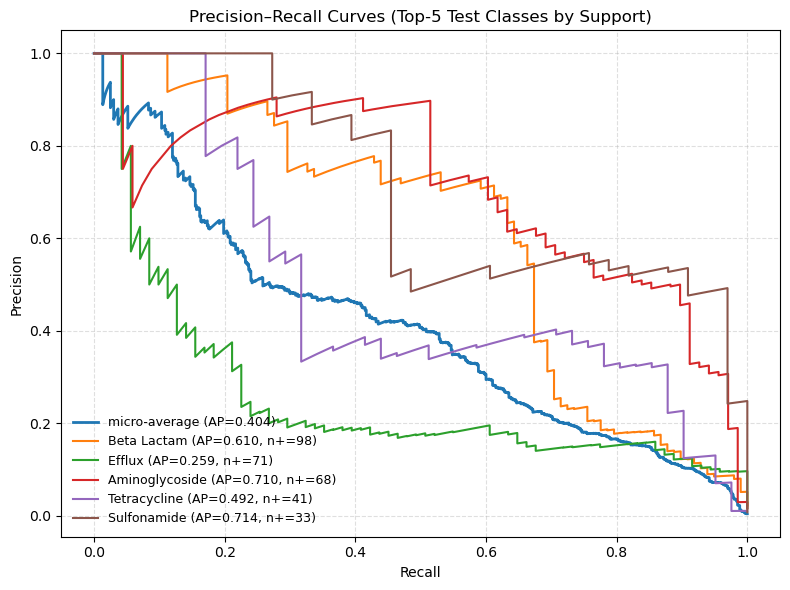

Saved figure to figures/pr_curves_top5.png


In [28]:
# === Cell 9b: Precision–Recall curves (per-class + micro-average) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Reuse logits/targets from Cell 9 if present; otherwise, rebuild from test_loader
if "logits" not in globals() or "targets" not in globals():
    model.eval()
    all_logits, all_targets = [], []
    with torch.no_grad():
        for xb, yb, tb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb, yb, tax_idx=None)
            all_logits.append(out["amr_logits"].cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    logits = np.concatenate(all_logits, axis=0)
    targets = np.concatenate(all_targets, axis=0)

# Convert logits to probabilities
probs = 1.0 / (1.0 + np.exp(-logits))  # sigmoid

# Determine class supports on the test set
supports = targets.sum(axis=0).astype(int)
valid_mask = supports > 0  # skip classes with no positives

# Choose top-k frequent classes to plot
k = min(5, int(valid_mask.sum()))
if k == 0:
    print("No classes with positives in test set; cannot plot PR curves.")
else:
    top_idx = np.argsort(supports)[::-1]  # descending by support
    top_idx = [i for i in top_idx if supports[i] > 0][:k]

    # Compute micro-average PR (flatten across classes)
    y_true_flat = targets[:, valid_mask].ravel()
    y_prob_flat = probs[:, valid_mask].ravel()
    p_micro, r_micro, _ = precision_recall_curve(y_true_flat, y_prob_flat)
    ap_micro = average_precision_score(y_true_flat, y_prob_flat)

    # Print summary table
    print("Class supports (test split) and AP for plotted classes:")
    rows = []
    for i in top_idx:
        y_true = targets[:, i]
        y_prob = probs[:, i]
        ap = average_precision_score(y_true, y_prob)
        rows.append((class_list[i], supports[i], ap))
    for name, sup, ap in rows:
        print(f"  {name:30s}  positives={sup:5d}  AP={ap:.4f}")
    print(f"\nMicro-average AP over valid classes: {ap_micro:.4f}")

    # Plot PR curves
    plt.figure(figsize=(8, 6))
    # Micro-average first
    plt.plot(r_micro, p_micro, linewidth=2, label=f"micro-average (AP={ap_micro:.3f})")

    # Per-class curves
    for i in top_idx:
        y_true = targets[:, i]
        y_prob = probs[:, i]
        p, r, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        plt.plot(r, p, linewidth=1.5, label=f"{class_list[i]} (AP={ap:.3f}, n+={supports[i]})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves (Top-5 Test Classes by Support)")
    plt.legend(loc="lower left", fontsize=9, frameon=False)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()

    # Save figure
    import os
    os.makedirs("figures", exist_ok=True)
    plt.savefig("figures/pr_curves_top5.png", dpi=200)
    plt.show()
    print("Saved figure to figures/pr_curves_top5.png")


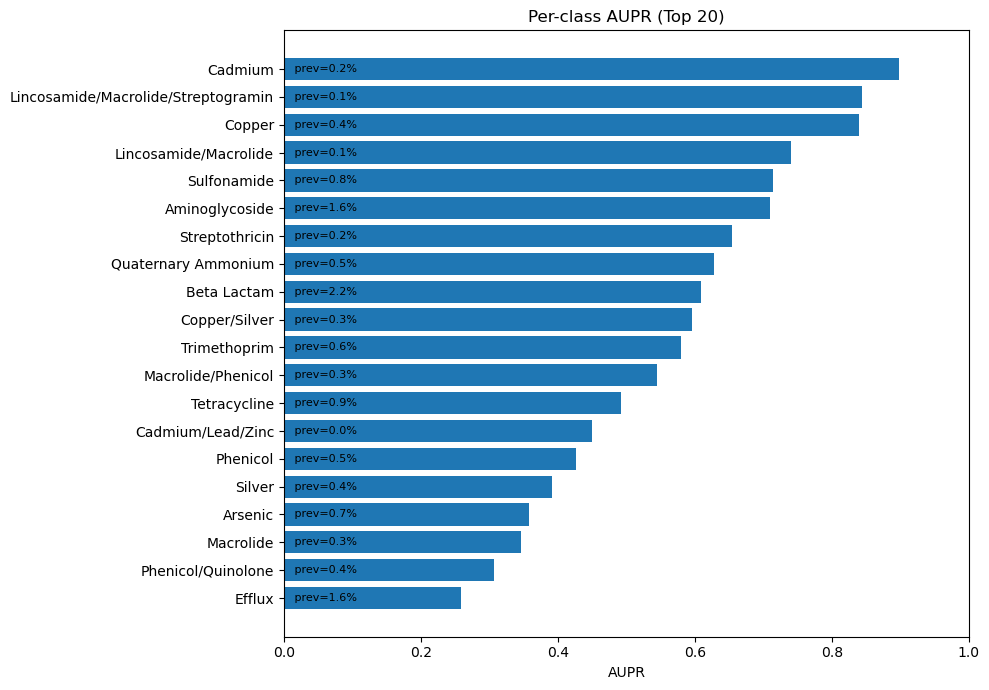

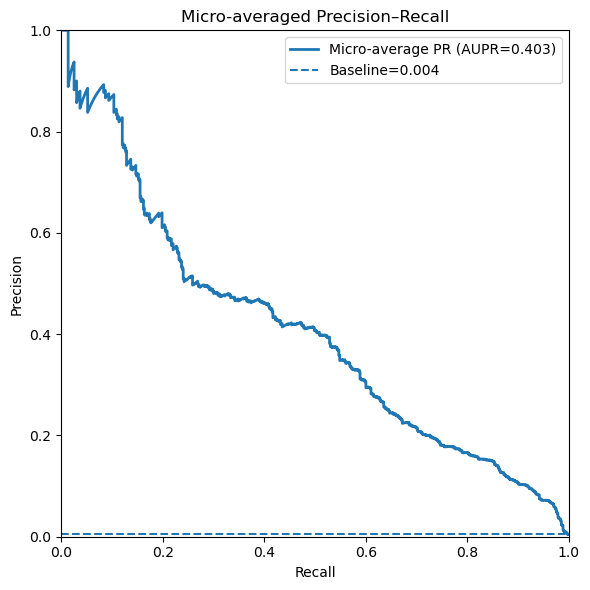

In [29]:
# === Clean summary plots: per-class AUPR (bar) + micro-PR curve ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

# Safety checks
assert probs.shape == targets.shape, "probs and targets must have same shape [N_test, C]"
C = targets.shape[1]

# --- Compute per-class AUPR and prevalence ---
aupr_per_class = []
prev_per_class = []
valid_mask = []

for c in range(C):
    y_true = targets[:, c]
    y_prob = probs[:, c]
    has_pos = (y_true.sum() > 0)
    if has_pos:
        aupr = average_precision_score(y_true, y_prob)
        aupr_per_class.append(aupr)
        prev_per_class.append(float(y_true.mean()))  # prevalence = positives/N
        valid_mask.append(True)
    else:
        # mark invalid (no positives) to exclude from bar chart
        aupr_per_class.append(np.nan)
        prev_per_class.append(0.0)
        valid_mask.append(False)

aupr_arr = np.array(aupr_per_class)
prev_arr = np.array(prev_per_class)
valid_idx = np.where(np.isfinite(aupr_arr))[0]

# --- Figure 1: Per-class AUPR bar chart (top 20) ---
top_k = min(20, len(valid_idx))
order = np.argsort(aupr_arr[valid_idx])  # ascending
sel = valid_idx[order][-top_k:]          # take best K
# sort selected by AUPR ascending for nice bars
sel_sorted = sel[np.argsort(aupr_arr[sel])]

plt.figure(figsize=(10, 7))
plt.barh([class_list[i] for i in sel_sorted], aupr_arr[sel_sorted])
plt.xlabel("AUPR")
plt.title(f"Per-class AUPR (Top {top_k})")
plt.xlim(0, 1.0)
# add prevalence annotations
for y, i in enumerate(sel_sorted):
    plt.text(0.01, y, f" prev={prev_arr[i]*100:.1f}%", va='center', fontsize=8, color='black')
plt.tight_layout()
plt.show()

# --- Figure 2: Micro-averaged PR curve ---
# Micro-average: ravel all classes (valid only) to a single binary problem
valid_cols = valid_idx.tolist()
if len(valid_cols) > 0:
    y_true_micro = targets[:, valid_cols].ravel()
    y_prob_micro = probs[:, valid_cols].ravel()

    precision, recall, _ = precision_recall_curve(y_true_micro, y_prob_micro)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, lw=2, label=f"Micro-average PR (AUPR={pr_auc:.3f})")
    # baseline = prevalence across valid classes
    baseline = y_true_micro.mean() if y_true_micro.size > 0 else 0.0
    plt.hlines(baseline, 0, 1, linestyles="dashed", label=f"Baseline={baseline:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Micro-averaged Precision–Recall")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No valid classes with positives to plot micro-PR.")


/var/folders/41/bxz6bq8116vf8vmlk8wl990m0000gn/T/ipykernel_13800/2484188986.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=freq_df, x="Count", y="AMR_Class", palette="viridis")


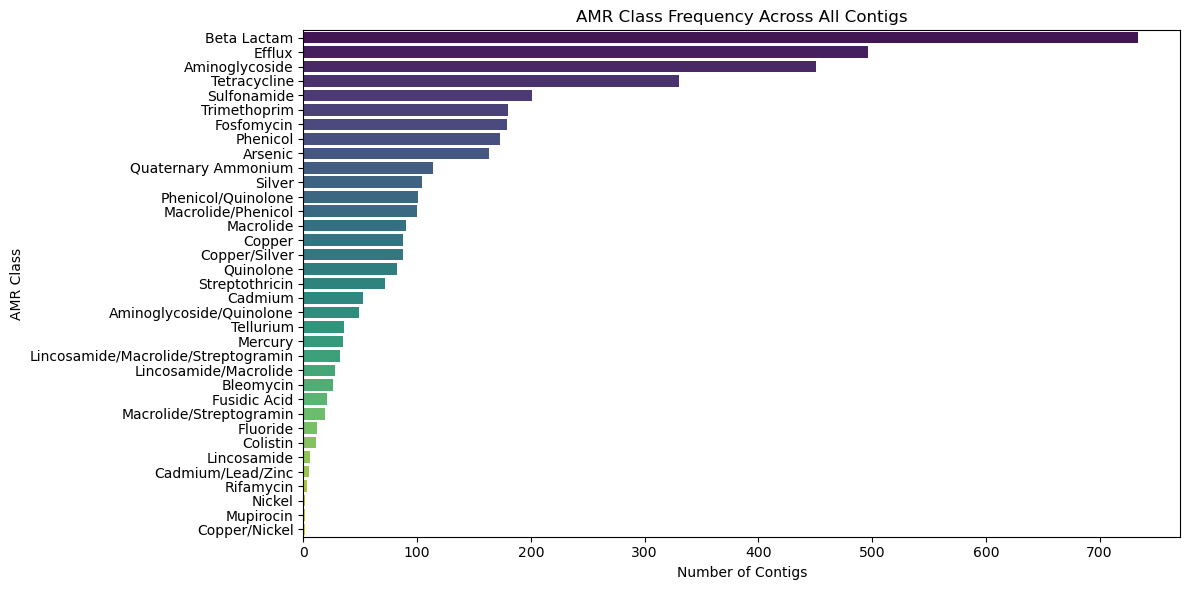

,AMR_Class,Count
3,Beta Lactam,734.0
11,Efflux,496.0
0,Aminoglycoside,451.0
33,Tetracycline,330.0
31,Sulfonamide,201.0
34,Trimethoprim,180.0
13,Fosfomycin,179.0
24,Phenicol,173.0
2,Arsenic,163.0
26,Quaternary Ammonium,114.0


In [14]:
# === AMR CLASS FREQUENCY PLOT ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# count positives per class
amr_freq = np.sum(Y_amr, axis=0)

freq_df = pd.DataFrame({
    "AMR_Class": class_list,
    "Count": amr_freq
}).sort_values("Count", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=freq_df, x="Count", y="AMR_Class", palette="viridis")
plt.title("AMR Class Frequency Across All Contigs")
plt.xlabel("Number of Contigs")
plt.ylabel("AMR Class")
plt.tight_layout()
plt.show()

freq_df.head(10)


In [18]:
# === Build df['seq_len'] robustly (works even if df['sequence'] is missing) ===
from pathlib import Path

def fasta_to_len_map(paths):
    """Return {contig_id: length} across one or more multi-FASTA files."""
    m = {}
    for path in paths:
        path = str(path)
        if not Path(path).exists():
            print(f"[warn] FASTA not found: {path}")
            continue
        with open(path, "r") as fh:
            header = None
            length = 0
            for line in fh:
                if line.startswith(">"):
                    if header is not None:
                        m[header] = m.get(header, 0) + length
                    header = line[1:].strip().split()[0]
                    length = 0
                else:
                    s = line.strip()
                    if s:
                        length += len(s)
            if header is not None:
                m[header] = m.get(header, 0) + length
    return m

# 1) If sequences are already present, use them directly
if "sequence" in df.columns:
    df["seq_len"] = df["sequence"].astype(str).str.len()
else:
    # 2) Try to use precomputed contig length if you have it
    if "contig_length" in df.columns:
        df["seq_len"] = df["contig_length"].astype(int)
    else:
        # 3) Recompute from FASTA files
        FASTA_FILES = [
            "/Users/jackpapciak/amr_project/raw_genomes/escherichia_coli/BVBRC_escherichia_coli_genome_100_sequences.fasta",
            "/Users/jackpapciak/amr_project/raw_genomes/klebsiella_pneumoniae/BVBRC_klebsiella_pneumoniae_genome_100_sequences.fasta",
            "/Users/jackpapciak/amr_project/raw_genomes/staphylococcus_aureus/BVBRC_staphylococcus_aureus_genome_100_sequences.fasta",
        ]
        LEN_MAP = fasta_to_len_map(FASTA_FILES)

        # exact match, then fallback to right-of-pipe token
        def right_of_pipe(x):
            t = str(x)
            return t.split("|")[-1] if "|" in t else t

        df["seq_len"] = df["contig_id"].map(LEN_MAP)
        missing = df["seq_len"].isna().sum()
        if missing:
            df.loc[df["seq_len"].isna(), "seq_len"] = (
                df.loc[df["seq_len"].isna(), "contig_id"].map(lambda cid: LEN_MAP.get(right_of_pipe(cid), None))
            )
        still_missing = int(df["seq_len"].isna().sum())
        if still_missing:
            print(f"[note] {still_missing} contigs still lack length (not found in FASTAs). They will be dropped in plots.")
            df = df[~df["seq_len"].isna()].copy()

df["seq_len"] = df["seq_len"].astype(int)
print("Sequence length column ready. Example:", df["seq_len"].head().tolist())



Sequence length column ready. Example: [20497, 23491, 2735, 43568, 3368]


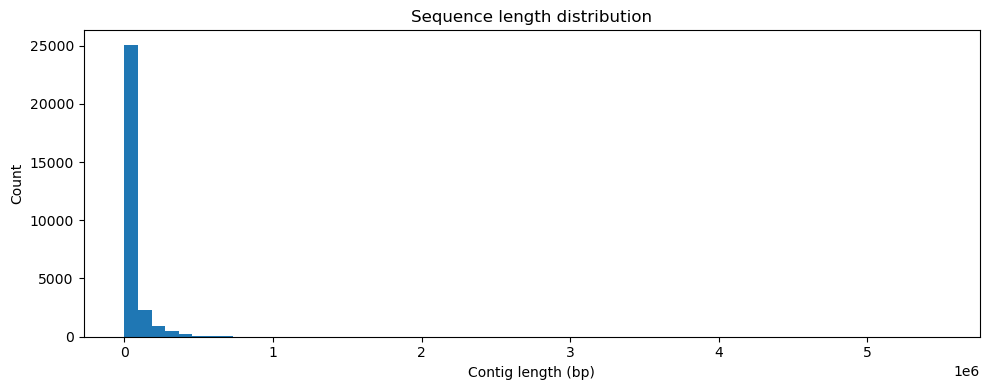

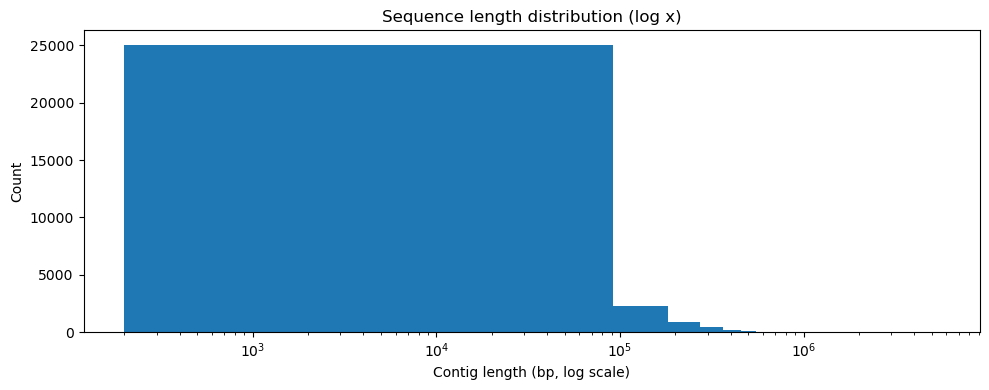

In [19]:
import numpy as np
import matplotlib.pyplot as plt

lens = df["seq_len"].to_numpy()
plt.figure(figsize=(10,4))
plt.hist(lens, bins=60)
plt.xlabel("Contig length (bp)")
plt.ylabel("Count")
plt.title("Sequence length distribution")
plt.tight_layout()
plt.show()

# Optional: log-scale x-axis if lengths are wide-ranging
plt.figure(figsize=(10,4))
plt.hist(lens, bins=60, log=False)
plt.xscale("log")
plt.xlabel("Contig length (bp, log scale)")
plt.ylabel("Count")
plt.title("Sequence length distribution (log x)")
plt.tight_layout()
plt.show()


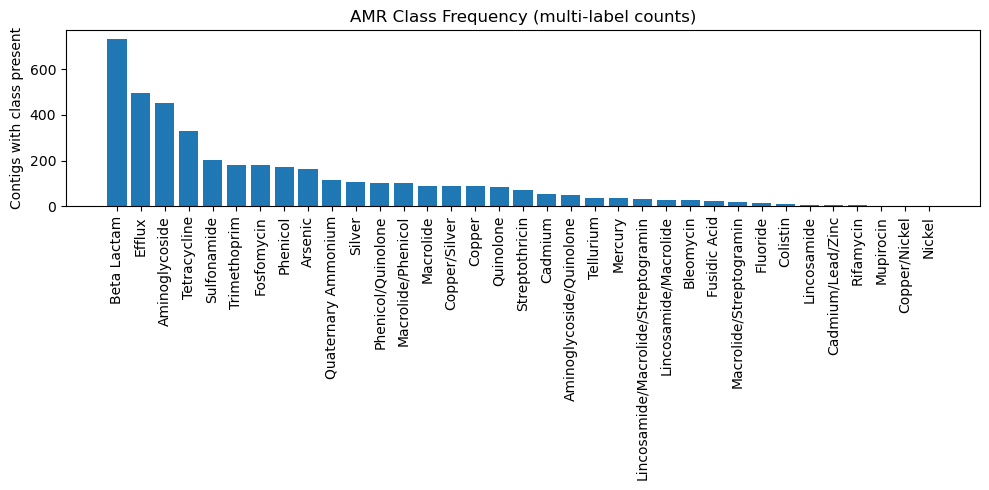

In [21]:
# AMR class frequency (bar chart)
import json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Try to load class_list if missing
if 'class_list' not in globals():
    # adjust if your JSON lives elsewhere
    ARTIFACTS_DIR = Path("/Users/jackpapciak/amr_project/misc/amrfinder_outputs")
    CLASSES_JSON  = ARTIFACTS_DIR / "amr_class_list.json"
    if CLASSES_JSON.exists():
        with open(CLASSES_JSON) as f:
            class_list = json.load(f)["class_list"]
    else:
        # fall back to generic names
        max_len = int(pd.Series(df["label_vector"]).map(len).max())
        class_list = [f"Class_{i}" for i in range(max_len)]

# Build a class-frequency vector by summing multi-hot label vectors
# Ensure label_vector is numpy arrays
lv = df["label_vector"].apply(lambda v: np.array(v, dtype=np.float32))
# Verify consistent length
L = int(lv.map(len).median())
assert (lv.map(len) == L).all(), "Inconsistent label_vector lengths"
mat = np.stack(lv.to_list())  # shape (N, L)
freq = mat.sum(axis=0)

# Sort descending
idx_sorted = np.argsort(-freq)
freq_sorted = freq[idx_sorted]
labels_sorted = [class_list[i] for i in idx_sorted]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(freq_sorted)), freq_sorted)
plt.xticks(range(len(freq_sorted)), labels_sorted, rotation=90)
plt.ylabel("Contigs with class present")
plt.title("AMR Class Frequency (multi-label counts)")
plt.tight_layout()
plt.show()



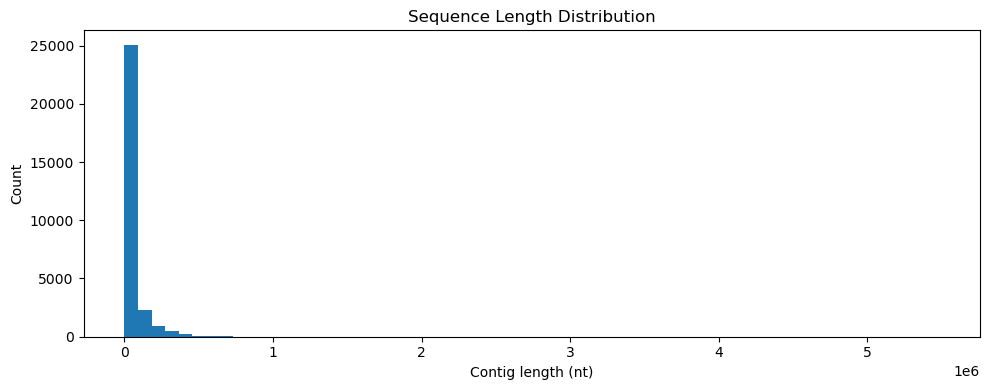

Sequence lengths: n=29176, mean=46555.8, median=4665.0, max=5482865


In [22]:
# Sequence length histogram (rebuild df['sequence'] if absent)
import matplotlib.pyplot as plt
from collections import ChainMap

def fasta_to_map(path):
    m = {}
    with open(path, "r") as fh:
        header = None
        chunks = []
        for line in fh:
            if line.startswith(">"):
                if header is not None:
                    m[header] = "".join(chunks)
                header = line[1:].strip().split()[0]
                chunks = []
            else:
                s = line.strip()
                if s:
                    chunks.append(s)
        if header is not None:
            m[header] = "".join(chunks)
    return m

def right_of_pipe(x: str):
    t = str(x)
    return t.split("|")[-1] if "|" in t else t

# Ensure df['sequence'] exists
if "sequence" not in df.columns or df["sequence"].isna().any():
    # Try to rebuild from the three FASTAs used earlier
    FASTA_FILES = [
        "/Users/jackpapciak/amr_project/raw_genomes/escherichia_coli/BVBRC_escherichia_coli_genome_100_sequences.fasta",
        "/Users/jackpapciak/amr_project/raw_genomes/klebsiella_pneumoniae/BVBRC_klebsiella_pneumoniae_genome_100_sequences.fasta",
        "/Users/jackpapciak/amr_project/raw_genomes/staphylococcus_aureus/BVBRC_staphylococcus_aureus_genome_100_sequences.fasta",
    ]
    seq_maps = []
    for p in FASTA_FILES:
        if Path(p).exists():
            seq_maps.append(fasta_to_map(p))
    SEQ_MAP = dict(ChainMap(*seq_maps)) if seq_maps else {}

    df = df.copy()
    df["sequence"] = df["contig_id"].map(SEQ_MAP)
    missing = df["sequence"].isna().sum()
    if missing:
        df.loc[df["sequence"].isna(), "sequence"] = (
            df.loc[df["sequence"].isna(), "contig_id"].map(lambda cid: SEQ_MAP.get(right_of_pipe(cid), None))
        )

# Now compute lengths, dropping any remaining missing sequences
seq_len = df["sequence"].dropna().astype(str).map(len)

plt.figure(figsize=(10, 4))
plt.hist(seq_len.values, bins=60)
plt.xlabel("Contig length (nt)")
plt.ylabel("Count")
plt.title("Sequence Length Distribution")
plt.tight_layout()
plt.show()

print(f"Sequence lengths: n={len(seq_len)}, mean={seq_len.mean():.1f}, median={seq_len.median():.1f}, max={seq_len.max()}")
missing_final = df["sequence"].isna().sum()
if missing_final:
    print(f"WARNING: {missing_final} contigs still missing sequences; excluded from histogram.")


In [24]:
# === PCA input sanity + repair ===
import numpy as np
import pandas as pd

# 0) Basic checks on df and sequences
assert 'sequence' in df.columns, "df['sequence'] missing — rerun the FASTA attach step."
assert 'is_amr_positive' in df.columns, "df['is_amr_positive'] missing — rerun the AMR label build step."

# 1) Rebuild (or reuse) hashed embeddings as needed
def _has_X_seq_in_scope():
    return 'X_seq' in globals() and isinstance(X_seq, np.ndarray) and X_seq.ndim == 2

if not _has_X_seq_in_scope():
    print("Rebuilding X_seq with current hashing params…")
    X_seq = np.stack([hash_kmers_fast(s) for s in df['sequence'].astype(str).values])

print("X_seq shape:", X_seq.shape)

# 2) Make a validity mask:
#    - contig has a non-empty sequence of length >= K
#    - hashed vector is finite and has at least one nonzero entry
seq_len = df['sequence'].astype(str).map(len).values
finite_mask = np.isfinite(X_seq).all(axis=1)
nonzero_mask = (X_seq.sum(axis=1) > 0)
len_mask = (seq_len >= K)

valid_mask = finite_mask & nonzero_mask & len_mask

n_valid = int(valid_mask.sum())
print(f"Valid rows for PCA: {n_valid}/{len(df)}")

# 3) Build the clean matrix and labels for PCA
X_clean = X_seq[valid_mask].astype(np.float32)
is_pos_clean = df.loc[valid_mask, 'is_amr_positive'].astype(bool).values

# 4) Optional: standardize features (helps PCA)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
X_clean_std = scaler.fit_transform(X_clean)

print("X_clean_std shape:", X_clean_std.shape,
      "| any NaN:", np.isnan(X_clean_std).any(),
      "| any Inf:", np.isinf(X_clean_std).any())



X_seq shape: (29176, 4096)
Valid rows for PCA: 29176/29176
X_clean_std shape: (29176, 4096) | any NaN: False | any Inf: False


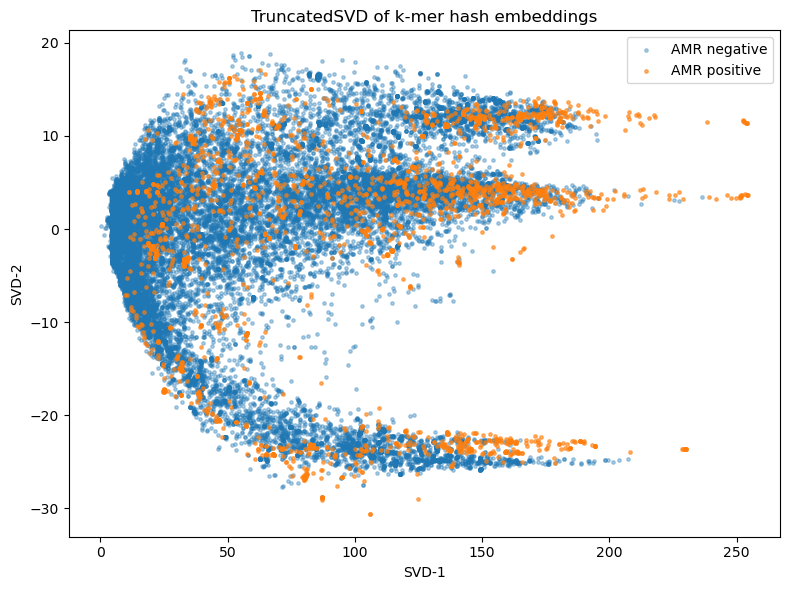

Explained variance (components): [0.9137176  0.03420662]
Total explained variance: 0.948


In [26]:
# ==== PCA-like visualization using TruncatedSVD (robust for k-mer hashes) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# 1) Get features and labels; ensure finite
X = np.asarray(X_seq, dtype=np.float64)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

is_pos = df["is_amr_positive"].astype(bool).to_numpy()
if X.shape[0] != is_pos.shape[0]:
    raise ValueError(f"Mismatch: X rows={X.shape[0]} vs labels={is_pos.shape[0]}")

# 2) Project to 2D
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X)  # no centering/standardization (intentional)

# 3) Plot
plt.figure(figsize=(8,6))
plt.scatter(X_2d[~is_pos,0], X_2d[~is_pos,1], s=6, alpha=0.35, label="AMR negative")
plt.scatter(X_2d[ is_pos,0], X_2d[ is_pos,1], s=6, alpha=0.6,  label="AMR positive")
plt.xlabel("SVD-1"); plt.ylabel("SVD-2"); plt.title("TruncatedSVD of k-mer hash embeddings")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Explained variance (components): {svd.explained_variance_ratio_}")
print(f"Total explained variance: {svd.explained_variance_ratio_.sum():.3f}")
